In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype

from Features import *
from AttributeRelevance import *

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)  

In [3]:
df = pd.read_csv('data/telco_churn.csv', na_values=[' '])

In [4]:
df.columns = [c[0].lower() + c[1:] for c in df.columns]
df['label'] = df['churn'].map({'Yes': 1, 'No': 0})
df['seniorCitizen'] = df['seniorCitizen'].map({1: 'Yes', 0: 'No'})
df.drop(['customerID', 'churn'], axis=1, inplace=True)

In [5]:
df.sample(5)

,gender,seniorCitizen,partner,dependents,tenure,phoneService,multipleLines,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTV,streamingMovies,contract,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,label
2064,Female,No,Yes,Yes,30,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),19.55,608.50,0
602,Female,No,Yes,Yes,66,Yes,Yes,Fiber optic,No,No,No,No,No,No,One year,Yes,Bank transfer (automatic),74.25,"4,859.25",0
3763,Male,No,Yes,No,4,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,80.35,307.40,1
5630,Female,No,No,No,39,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,103.45,"3,994.45",1
2954,Female,No,No,No,7,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Mailed check,75.45,480.75,1


In [6]:
feats_dict = {}
black_list = ['onlineSecurity', 'techSupport', 'onlineBackup', 'streamingTV', 'streamingMovies', 'deviceProtection']

for col in [c for c in df.columns if c not in black_list and c != 'label']:
    if is_numeric_dtype(df[col]):
        feats_dict[col] = ContinuousFeature(df, col)
    else:
        feats_dict[col] = CategoricalFeature(df, col)

feats = list(feats_dict.values())

In [7]:
iv = IV()
s = StatsSignificance()

ar = AttributeRelevance()

In [8]:
ar.analyze(feats, iv, s, interpretation=True)

C:\Users\klaud\Anaconda3\envs\master\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\klaud\Anaconda3\envs\master\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,p-value,effect_size,iv_interpretation,es_interpretation
contract,1.24,0.00,0.41,suspicious,strong
tenure,0.85,0.00,0.38,suspicious,medium
internetService,0.62,0.00,0.32,suspicious,medium
paymentMethod,0.46,0.00,0.30,strong,medium
totalCharges,0.32,0.00,0.25,strong,medium
paperlessBilling,0.20,0.00,0.19,medium,weak
monthlyCharges,0.17,0.00,0.18,medium,weak
dependents,0.16,0.00,0.16,medium,weak
partner,0.12,0.00,0.15,medium,weak
seniorCitizen,0.11,0.00,0.15,medium,weak


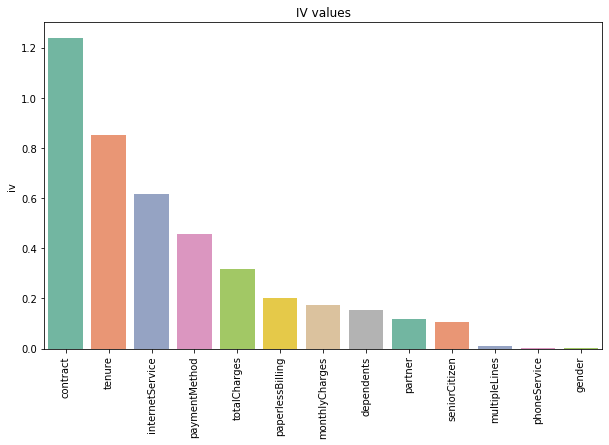

In [9]:
ar.draw_iv(feats, iv)

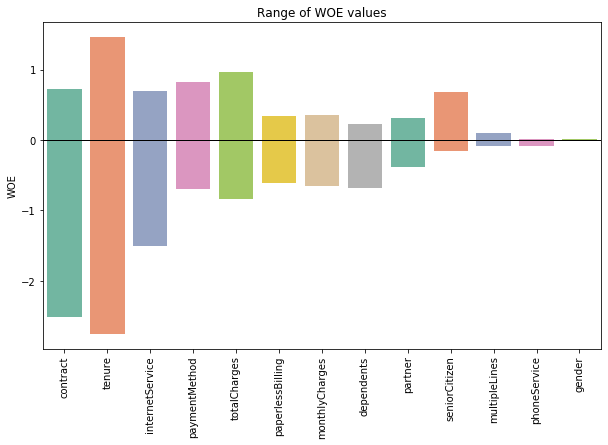

In [10]:
ar.draw_woe_extremes(feats, iv)

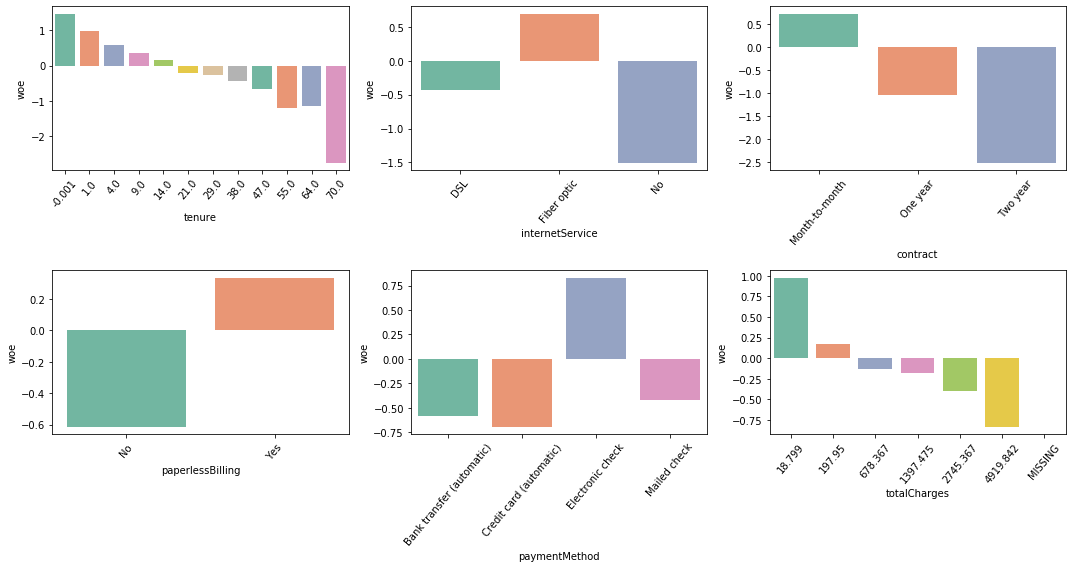

In [19]:
f_draw = ['contract', 'tenure', 'internetService', 'paymentMethod', 'totalCharges', 'paperlessBilling']
feats_draw = [v for k, v in feats_dict.items() if k in f_draw]
ar.draw_woe_multiplot(feats_draw, iv)

In [21]:
feats_dict_black = {}
df_black = df[df['internetService']!='No']
for b in black_list:
    feats_dict_black[b] = CategoricalFeature(df_black, b)

feats_black = list(feats_dict_black.values())

In [23]:
ar.analyze(feats_black, iv, s, interpretation=True)

,iv,p-value,effect_size,iv_interpretation,es_interpretation
onlineSecurity,0.42,0.00,0.28,strong,medium
techSupport,0.39,0.00,0.27,strong,medium
onlineBackup,0.18,0.00,0.20,medium,weak
deviceProtection,0.15,0.00,0.18,medium,weak
streamingMovies,0.01,0.00,0.04,useless,useless
streamingTV,0.01,0.01,0.04,useless,useless


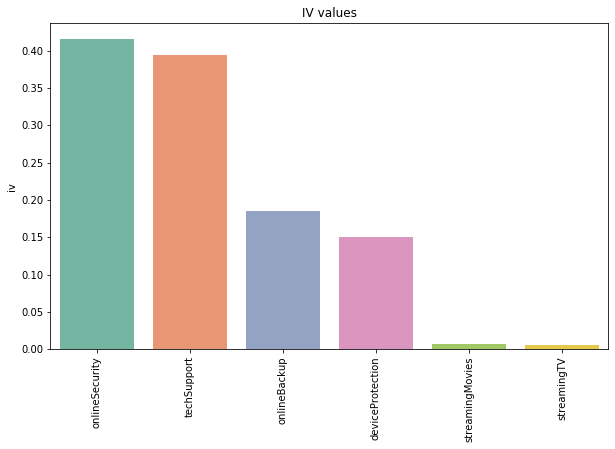

In [24]:
ar.draw_iv(feats_black, iv)

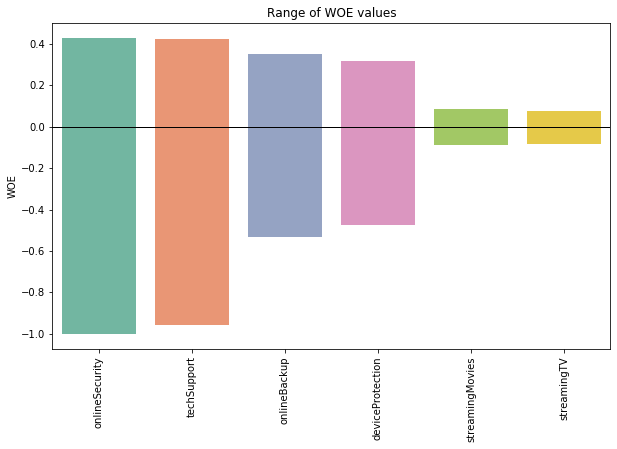

In [25]:
ar.draw_woe_extremes(feats_black, iv)

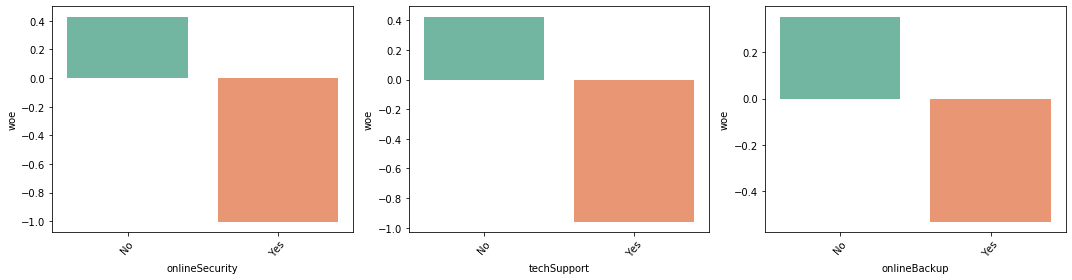

In [32]:
f_black_draw = ['onlineSecurity', 'techSupport', 'onlineBackup']
feats_black_draw = [v for k, v in feats_dict_black.items() if k in f_black_draw]
ar.draw_woe_multiplot(feats_black_draw, iv)

In [205]:
def evaluate_feature(feature, feats_group=feats_dict):
    iv.draw_woe(feats_group[feature])
    iv.print_iv(feats_group[feature])
    print('')
    s.print_chi(feats_group[feature])

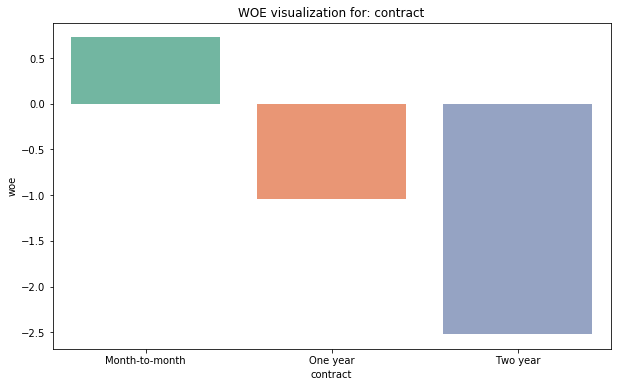

Information value: 1.24
Contract is a suspicious predictor

P-value: 0.00
Effect size: 0.41
Contract is a strong predictor


In [206]:
evaluate_feature('contract')

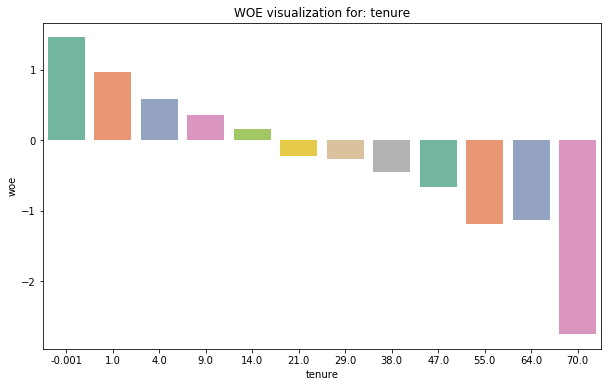

Information value: 0.85
Tenure is a suspicious predictor

P-value: 0.00
Effect size: 0.38
Tenure is a medium predictor


In [207]:
evaluate_feature('tenure')

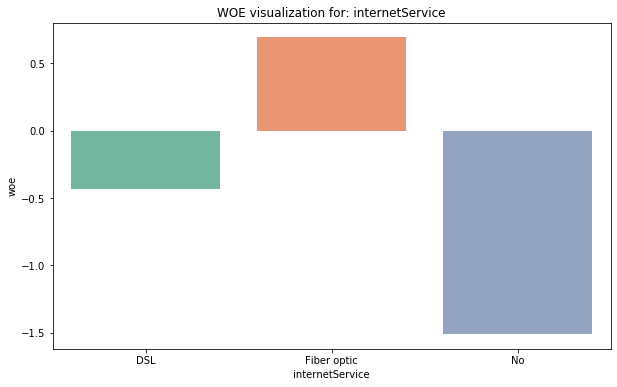

Information value: 0.62
Internetservice is a suspicious predictor

P-value: 0.00
Effect size: 0.32
Internetservice is a medium predictor


In [208]:
evaluate_feature('internetService')

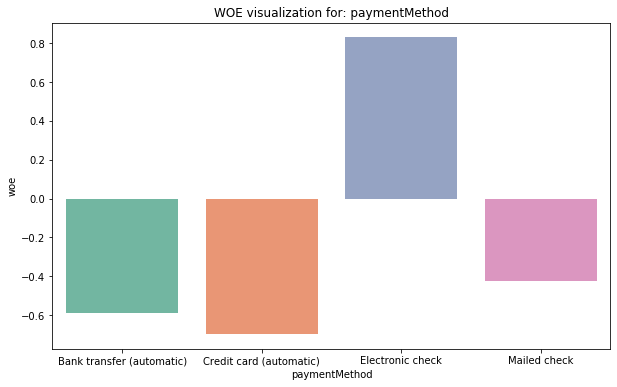

Information value: 0.46
Paymentmethod is a strong predictor

P-value: 0.00
Effect size: 0.30
Paymentmethod is a medium predictor


In [209]:
evaluate_feature('paymentMethod')

In [210]:
iv.group_by_feature(feats_dict['paymentMethod'])

,paymentMethod,count,good,bad
0,Bank transfer (automatic),1544,258,1286
1,Credit card (automatic),1522,232,1290
2,Electronic check,2365,1071,1294
3,Mailed check,1612,308,1304


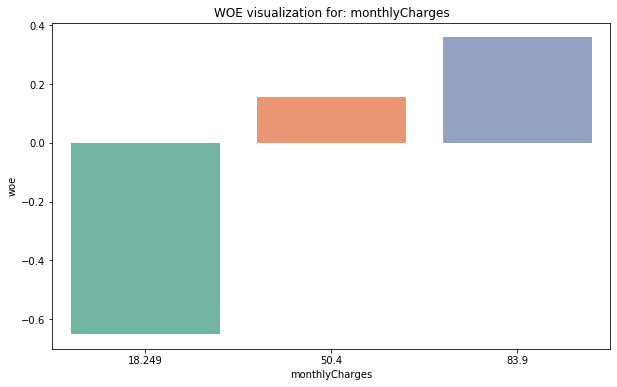

Information value: 0.17
Monthlycharges is a medium predictor

P-value: 0.00
Effect size: 0.18
Monthlycharges is a weak predictor


In [211]:
evaluate_feature('monthlyCharges')

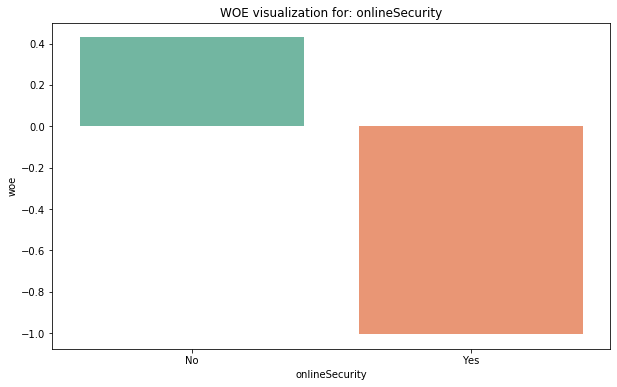

Information value: 0.42
Onlinesecurity is a strong predictor

P-value: 0.00
Effect size: 0.28
Onlinesecurity is a medium predictor


In [212]:
evaluate_feature('onlineSecurity', feats_group=feats_dict_black)

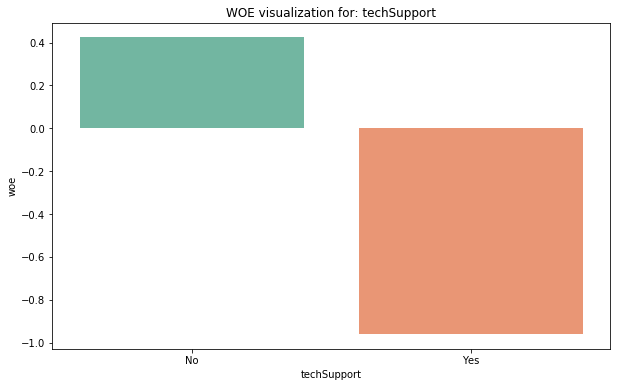

Information value: 0.39
Techsupport is a strong predictor

P-value: 0.00
Effect size: 0.27
Techsupport is a medium predictor


In [213]:
evaluate_feature('techSupport', feats_group=feats_dict_black)

* customerIDCustomer ID
* genderWhether the customer is a male or a female
* SeniorCitizenWhether the customer is a senior citizen or not (1, 0)
* PartnerWhether the customer has a partner or not (Yes, No)
* DependentsWhether the customer has dependents or not (Yes, No)
* tenureNumber of months the customer has stayed with the company
* PhoneServiceWhether the customer has a phone service or not (Yes, No)
* MultipleLinesWhether the customer has multiple lines or not (Yes, No, No phone service)
* InternetServiceCustomer’s internet service provider (DSL, Fiber optic, No)
* OnlineSecurityWhether the customer has online security or not (Yes, No, No internet service)
* OnlineBackupWhether the customer has online backup or not (Yes, No, No internet service)
* DeviceProtectionWhether the customer has device protection or not (Yes, No, No internet service)
* TechSupportWhether the customer has tech support or not (Yes, No, No internet service)
* StreamingTVWhether the customer has streaming TV or not (Yes, No, No internet service)
* StreamingMoviesWhether the customer has streaming movies or not (Yes, No, No internet service)
* ContractThe contract term of the customer (Month-to-month, One year, Two year)
* PaperlessBillingWhether the customer has paperless billing or not (Yes, No)
* PaymentMethodThe customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* MonthlyChargesThe amount charged to the customer monthly
* TotalChargesThe total amount charged to the customer
* ChurnWhether the customer churned or not (Yes or No)